In [1]:
import pandas as pd
import numpy as np
import seaborn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

In [2]:
raw_file = pd.read_csv("data/overall_stats_salary.csv")
raw_file

,season,seas_id,player_id,player,birth_year,pos,age,tm,experience,g,...,ts_percent_y,e_fg_percent,tov_percent_y,orb_percent_y,ft_fga,opp_e_fg_percent,opp_tov_percent,opp_drb_percent,opp_ft_fga,salary
0,1990,11801,2218,A.C. Green,NaN,PF,26,LAL,5,82,...,0.562,0.512,13.2,32.8,0.271,0.479,12.8,68.5,0.219,4110398.0
1,1990,11803,2479,Adrian Caldwell,NaN,PF,23,HOU,1,51,...,0.531,0.491,15.5,33.1,0.225,0.475,14.7,69.2,0.228,645919.0
2,1990,11804,1692,Adrian Dantley,NaN,SF,34,DAL,14,45,...,0.536,0.487,13.6,30.3,0.254,0.481,13.4,67.9,0.232,939519.0
3,1990,11805,1693,Alex English,NaN,SF,36,DEN,14,80,...,0.523,0.478,11.2,29.1,0.217,0.501,15.2,71.3,0.264,3523198.0
4,1990,11806,2480,Alexander Volkov,NaN,C,25,ATL,1,72,...,0.547,0.496,13.5,36.3,0.277,0.509,14.0,65.5,0.254,1526719.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15636,2023,31131,4580,Zach Collins,NaN,C,25,SAS,5,63,...,0.554,0.525,13.0,25.6,0.170,0.576,12.0,74.9,0.201,7700000.0
15637,2023,31132,4299,Zach LaVine,NaN,SG,27,CHI,9,77,...,0.587,0.550,12.2,20.1,0.203,0.544,13.5,77.8,0.197,40064220.0
15638,2023,31133,4898,Zeke Nnaji,NaN,PF,22,DEN,3,53,...,0.601,0.573,13.1,24.8,0.194,0.543,12.2,76.4,0.201,4306281.0
15639,2023,31134,5024,Ziaire Williams,NaN,SF,21,MEM,2,37,...,0.570,0.540,11.7,26.5,0.190,0.526,13.1,75.9,0.206,4810200.0


Fix players that player that play multiple position

<Axes: title={'center': 'Player distribution by position'}, xlabel='pos'>

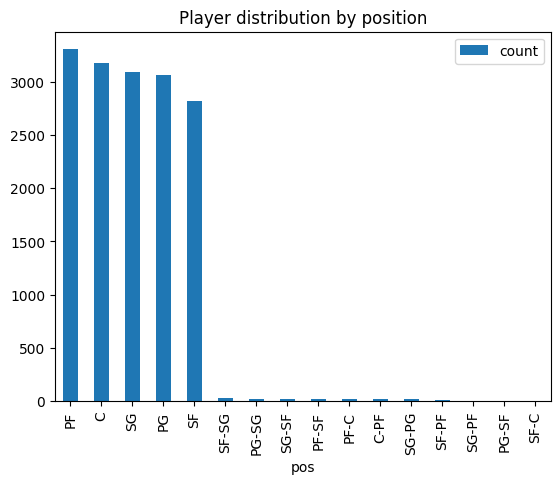

In [3]:
pd.DataFrame(raw_file["pos"].value_counts()).plot.bar(title = "Player distribution by position")

In [4]:
# Pick position that the player plays max
max_pos = raw_file[['pg_percent', 'sg_percent','sf_percent', 'pf_percent','c_percent']].idxmax(axis=1).str.split("_", expand = True).iloc[:,0].str.upper()
raw_file["pos"] = np.where(raw_file["pos"].str.len() > 2, max_pos, raw_file["pos"])
raw_file["pos"].value_counts()

pos
PF    3345
C     3205
SG    3128
PG    3088
SF    2865
Name: count, dtype: int64

Data Cleansing

In [5]:
columns_nas = pd.DataFrame(raw_file.isna().sum().sort_values(ascending=False)).head(15)
columns_nas

,0
birth_year,15451
nba roy_share,15425
nba roy_winner,15425
All-Rookie,15308
All-Defense,15308
smoy_share,15213
smoy_winner,15213
All-NBA,15149
dpoy_winner,15142
dpoy_share,15142


In [6]:
# Drop useless columns at the moment
useless = ["birth_year", "tm", "player", "season", "seas_id", "player_id"]
raw_file = raw_file.drop(columns = useless)

Feature Engineering - on Awards

In [7]:
# Awards + Position
to_binary = ["nba roy_winner", "smoy_winner", "dpoy_winner", "nba mvp_winner", "mip_winner"]
to_multiple_binary = ["All-Rookie", "All-Defense", "All-NBA", "pos"]
drop = ["nba roy_share", "smoy_share", "dpoy_share", "mip_share"]
keep_and_fill_0 = ["nba mvp_share"]

In [8]:
to_multiple_binary_df = pd.get_dummies(raw_file[to_multiple_binary], dtype=float)
to_multiple_binary_df

,All-Rookie_1st,All-Rookie_2nd,All-Defense_1st,All-Defense_2nd,All-NBA_1st,All-NBA_2nd,All-NBA_3rd,pos_C,pos_PF,pos_PG,pos_SF,pos_SG
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
15638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
for col in to_binary:
    raw_file[col] = raw_file[col].fillna(0).astype(int)

raw_file = pd.concat([raw_file.drop(columns = to_multiple_binary + drop), to_multiple_binary_df], axis=1)
for col in keep_and_fill_0:
    raw_file[col] = raw_file[col].fillna(0)

Feature Cleansing - Temporary drop Stats NA before 1996


In [10]:
missing_col_before_1996 = pd.DataFrame(raw_file.isna().sum())
missing_col_before_1996 = missing_col_before_1996[missing_col_before_1996 == 2533].dropna().index.tolist()
raw_file = raw_file.drop(columns = missing_col_before_1996)

In [11]:
numerical_features = raw_file.select_dtypes(exclude = ["object"]).columns
numerical_features = list(numerical_features.drop("salary"))


Feature Cleansing - Other Columns missing data

In [12]:
fill_with_mean_median = ["f_tr_y", "d_rtg_y", "ft_fga", "orb_percent_y", "tov_percent_y", "e_fg_percent", "ts_percent_y", "x3p_ar_y", 
                  "pace", "n_rtg", "o_rtg_y", "opp_drb_percent", "srs", "sos", "mov", "pl", "pw", "l", "w", "opp_tov_percent", "opp_e_fg_percent", 
                  "opp_ft_fga", "x3p_ar_x", "f_tr_x", "ts_percent_x", "tov_percent_x"]
fill_false = ["playoffs"]

<Axes: title={'center': 'Histrogram: Pace'}, ylabel='Frequency'>

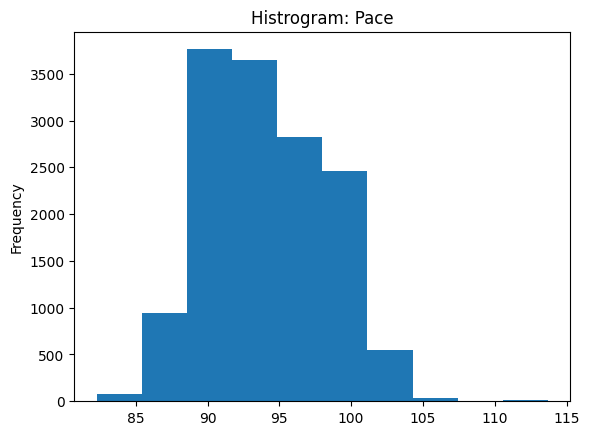

In [13]:
raw_file["pace"].plot.hist(title = "Histrogram: Pace")

<Axes: title={'center': 'Histrogram: f_tr_x'}, ylabel='Frequency'>

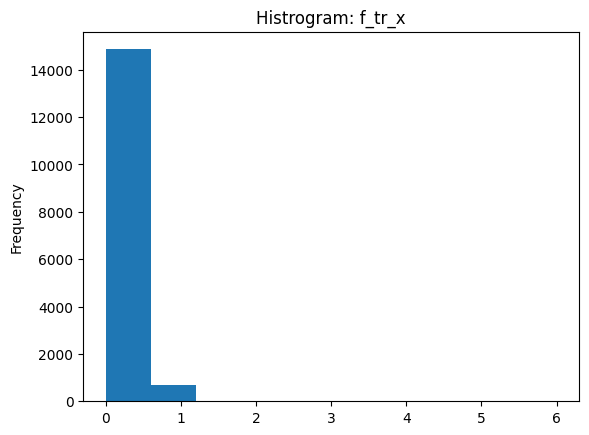

In [14]:
raw_file['f_tr_x'].plot.hist(title = "Histrogram: f_tr_x")

In [15]:
fill_with_mean, fill_with_median = [], []
for col in fill_with_mean_median:
    # Fill with median if large skewness, otherwise fill with mean
    if abs(raw_file[col].skew()) >= 1:
        fill_with_median.append(col)
        raw_file[col] = raw_file[col].fillna(raw_file[col].median())
    else:
        fill_with_mean.append(col)
        raw_file[col] = raw_file[col].fillna(raw_file[col].mean())

for col in fill_false:
    raw_file[col] = raw_file[col].fillna(False).astype(int)

In [16]:
fill_with_median

['f_tr_x', 'ts_percent_x', 'tov_percent_x']

In [17]:
len(fill_with_mean), len(fill_with_median)

(23, 3)

Drop few rows with empty values

In [18]:
print("Before", raw_file.shape)
raw_file = raw_file.dropna()
print("After", raw_file.shape)

Before (15641, 115)
After (15640, 115)


In [19]:
pd.options.display.max_columns=111
raw_file.head()

,age,experience,g,mp,per,ts_percent_x,x3p_ar_x,f_tr_x,orb_percent_x,drb_percent,trb_percent,ast_percent,stl_percent,blk_percent,tov_percent_x,usg_percent,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp,All Star?,share,x1st_tm,x2nd_tm,x3rd_tm,fg_per_36_min,fga_per_36_min,fg_percent_x,x3p_per_36_min,x3pa_per_36_min,x3p_percent_x,x2p_per_36_min,x2pa_per_36_min,x2p_percent_x,ft_per_36_min,fta_per_36_min,ft_percent_x,orb_per_36_min,drb_per_36_min,trb_per_36_min,ast_per_36_min,stl_per_36_min,blk_per_36_min,tov_per_36_min,pf_per_36_min,pts_per_36_min,fg_per_100_poss,fga_per_100_poss,fg_percent_y,x3p_per_100_poss,x3pa_per_100_poss,...,fta_per_100_poss,ft_percent_y,orb_per_100_poss,drb_per_100_poss,trb_per_100_poss,ast_per_100_poss,stl_per_100_poss,blk_per_100_poss,tov_per_100_poss,pf_per_100_poss,pts_per_100_poss,o_rtg_x,d_rtg_x,dpoy_winner,mip_winner,nba mvp_share,nba mvp_winner,nba roy_winner,smoy_winner,playoffs,w,l,pw,pl,mov,sos,srs,o_rtg_y,d_rtg_y,n_rtg,pace,f_tr_y,x3p_ar_y,ts_percent_y,e_fg_percent,tov_percent_y,orb_percent_y,ft_fga,opp_e_fg_percent,opp_tov_percent,opp_drb_percent,opp_ft_fga,salary,All-Rookie_1st,All-Rookie_2nd,All-Defense_1st,All-Defense_2nd,All-NBA_1st,All-NBA_2nd,All-NBA_3rd,pos_C,pos_PF,pos_PG,pos_SF,pos_SG
0,26,5,82,2709,14.7,0.548,0.057,0.459,11.5,18.4,15.1,4.6,1.2,1.1,10.7,17.1,4.4,3.3,7.7,0.137,0.3,-0.9,-0.6,1.0,1.0,0.0,0,0,0,5.1,10.7,0.478,0.2,0.6,0.283,4.9,10.1,0.489,3.7,4.9,0.751,3.5,6.0,9.5,1.2,0.9,0.7,1.5,2.8,14.1,7.1,14.8,0.478,0.2,0.8,...,6.8,0.751,4.8,8.3,13.1,1.7,1.2,0.9,2.1,3.8,19.5,116,107,0,0,0.0,0,0,0,1,63.0,19.0,58.0,24.0,6.78,-0.04,6.74,114.0,107.0,7.0,96.3,0.345,0.120,0.562,0.512,13.2,32.8,0.271,0.479,12.8,68.5,0.219,4110398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,23,1,51,331,9.5,0.549,0.000,0.368,11.7,22.9,17.4,2.8,1.6,3.2,26.6,14.8,-0.3,0.7,0.4,0.061,-5.3,1.4,-4.0,-0.2,0.0,0.0,0,0,0,4.6,8.3,0.553,0.0,0.0,0.000,4.6,8.3,0.553,1.4,3.0,0.464,3.9,7.9,11.9,0.8,1.2,2.0,3.5,7.5,10.5,6.0,10.9,0.553,0.0,0.0,...,4.0,0.464,5.2,10.5,15.6,1.0,1.6,2.6,4.6,9.9,13.9,91,100,0,0,0.0,0,0,0,1,41.0,41.0,45.0,37.0,1.46,0.24,1.71,104.8,103.4,1.4,101.2,0.313,0.068,0.531,0.491,15.5,33.1,0.225,0.475,14.7,69.2,0.228,645919.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,34,14,45,1300,15.4,0.556,0.004,0.525,6.9,8.1,7.5,9.6,0.8,0.3,11.2,22.6,2.2,0.8,3.1,0.113,0.9,-1.4,-0.4,0.5,0.0,0.0,0,0,0,6.4,13.4,0.477,0.0,0.1,0.000,6.4,13.3,0.479,5.5,7.0,0.787,2.2,2.6,4.8,2.2,0.6,0.2,2.1,2.7,18.3,9.0,18.9,0.477,0.0,0.1,...,9.9,0.787,3.0,3.7,6.7,3.1,0.8,0.3,2.9,3.9,25.9,113,112,0,0,0.0,0,0,0,1,47.0,35.0,41.0,41.0,0.07,0.35,0.42,107.2,107.2,0.0,94.5,0.331,0.071,0.536,0.487,13.6,30.3,0.254,0.481,13.4,67.9,0.232,939519.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,36,14,80,2211,17.9,0.522,0.004,0.142,5.3,8.4,6.8,15.6,1.1,0.6,6.3,26.0,3.3,1.7,5.1,0.110,2.5,-1.2,1.2,1.8,0.0,0.0,0,0,0,10.3,21.1,0.491,0.0,0.1,0.400,10.3,21.0,0.491,2.6,3.0,0.880,1.9,2.7,4.7,3.7,0.8,0.4,1.5,2.1,23.3,13.1,26.6,0.491,0.0,0.1,...,3.8,0.880,2.5,3.4,5.9,4.6,1.1,0.5,1.9,2.7,29.5,110,110,0,0,0.0,0,0,0,1,43.0,39.0,45.0,37.0,1.41,0.15,1.56,108.0,106.7,1.3,105.4,0.275,0.084,0.523,0.478,11.2,29.1,0.217,0.501,15.2,71.3,0.264,3523198.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,25,1,72,937,11.9,0.530,0.120,0.423,6.2,8.5,7.3,12.3,1.9,1.4,13.4,17.4,1.0,0.4,1.4,0.074,-1.3,0.1,-1.2,0.2,0.0,0.0,0,0,0,5.3,10.9,0.482,0.5,1.3,0.382,4.8,9.6,0.496,2.7,4.6,0.583,2.0,2.6,4.6,3.2,1.4,0.8,2.0,6.4,13.7,7.3,15.2,0.482,0.7,1.8,...,6.4,0.583,2.8,3.6,6.4,4.4,1.9,1.2,2.8,8.9,19.1,110,113,0,0,0.0,0,0,0,0,41.0,41.0,44.0,38.0,1.02,-0.39,0.64,113.0,111.9,1.1,95.8,0.362,0.059,0.547,0.496,13.5,36.3,0.277,0.509,14.0,65.5,0.254,1526719.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Y: Salary is highly skewed => transform that

2.191767147772739
5.658145814554576


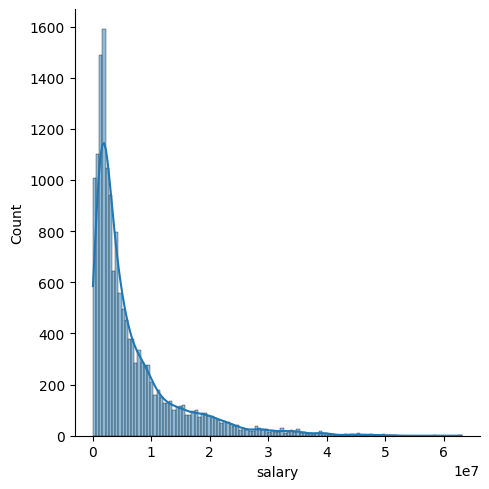

In [20]:
seaborn.displot(raw_file, x="salary", kde=True)
print(raw_file["salary"].skew())
print(raw_file["salary"].kurtosis())


In [21]:
raw_file["salary"] = np.log(raw_file["salary"])

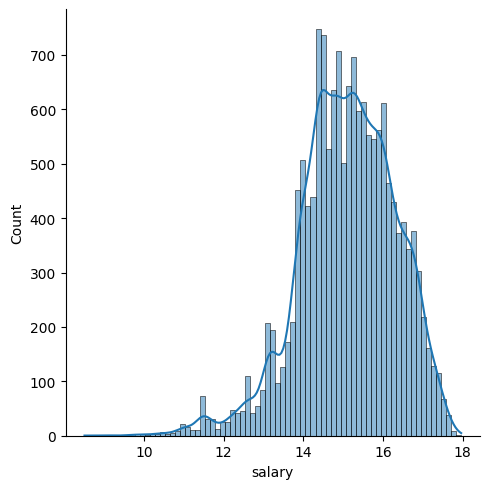

In [22]:
seaborn.displot(raw_file, x="salary", kde=True)

Data Modelling

In [23]:
evaluation = {}

Model 1: Simple Linear Regression

In [24]:
X = raw_file.drop(columns = ["salary"])
Y = raw_file["salary"]
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.3, random_state=0)

In [25]:
model = LinearRegression().fit(X_train, Y_train)
pred = model.predict(X_valid)

In [26]:
evaluation["Simple Linear Regression"] = [np.sqrt(mean_squared_error(y_true=Y_valid, y_pred=pred)), r2_score(y_true=Y_valid, y_pred=pred)]
print(evaluation["Simple Linear Regression"])

[0.8460486235462261, 0.5061678043052618]


In [27]:
plt.scatter(pred, Y_valid)

NameError: name 'pred_1' is not defined

Model 2: SVM

In [ ]:
model = SVR().fit(X_train, Y_train)
pred = model.predict(X_valid)

In [ ]:
evaluation["SVM"] = [np.sqrt(mean_squared_error(y_true=Y_valid, y_pred=pred)), r2_score(y_true=Y_valid, y_pred=pred)]
print(evaluation["SVM"])

[0.9132584243699476, 0.424591691843338]


Model 3: Decision Tree Regressor

In [ ]:
parameters={"splitter":["best","random"],
            "max_depth" : [5,7,9,11],
           "min_samples_leaf":[5,10,25,50],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4],
           "max_features":["log2","sqrt"],
           "max_leaf_nodes":[10,20,30,40,50] }

In [ ]:
model = DecisionTreeRegressor()
model = GridSearchCV(model, param_grid=parameters, scoring="neg_mean_squared_error", cv=5, verbose=3).fit(X_train, Y_train)
pred = model.predict(X_valid)

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits
[CV 1/5] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=nan total time=   0.0s
[CV 2/5] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=nan total time=   0.0s
[CV 3/5] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=nan total time=   0.0s
[CV 4/5] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=nan total time=   0.0s
[CV 5/5] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=nan total time=   0.0s
[CV 1/5] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=na

c:\Users\anson\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
3200 fits failed out of a total of 9600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3200 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\anson\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\anson\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\anson\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\anson\anaconda3\Lib\site-pac

In [ ]:
evaluation["Decision Tree"] = [np.sqrt(mean_squared_error(y_true=Y_valid, y_pred=pred)), r2_score(y_true=Y_valid, y_pred=pred)]
print(evaluation["Decision Tree"])

[0.9752969768315554, 0.3437602846436475]


Model 4: Random Forest Regressor

In [ ]:
model = RandomForestRegressor().fit(X_train, Y_train)
pred = model.predict(X_valid)

In [ ]:
evaluation["Random Forest"] = [np.sqrt(mean_squared_error(y_true=Y_valid, y_pred=pred)), r2_score(y_true=Y_valid, y_pred=pred)]
print(evaluation["Random Forest"])

[0.7833601863628058, 0.576638126531672]


Model 5: Elastic Net Regressor

In [ ]:
model = ElasticNetCV(cv=5, random_state=0).fit(X_train, Y_train)
pred = model.predict(X_valid)

In [ ]:
evaluation["Elastic Net"] = [np.sqrt(mean_squared_error(y_true=Y_valid, y_pred=pred)), r2_score(y_true=Y_valid, y_pred=pred)]
print(evaluation["Elastic Net"])

[0.9223028092044387, 0.41313823287805107]


Model 6: Histogram-based Gradient Boosting Regression Tree.

In [ ]:
model = HistGradientBoostingRegressor().fit(X_train, Y_train)
pred = model.predict(X_valid) 

In [ ]:
evaluation["HistGradientBoostingRegressor"] = [np.sqrt(mean_squared_error(y_true=Y_valid, y_pred=pred)), r2_score(y_true=Y_valid, y_pred=pred)]
print(evaluation["HistGradientBoostingRegressor"])

[0.7768678481072142, 0.583626529991571]


In [ ]:
evaluation_df = pd.DataFrame(evaluation, index = ["RMSE", "R^2"]).T
evaluation_df

,RMSE,R^2
Simple Linear Regression,0.846049,0.506168
SVM,0.913258,0.424592
Decision Tree,1.130066,0.118959
Random Forest,0.783360,0.576638
Elastic Net,0.922303,0.413138
HistGradientBoostingRegressor,0.776868,0.583627
